In [1]:
%matplotlib inline
import os
import pandas as pd
import numpy as np

import matplotlib as mpl
# mpl.use('Agg')
import matplotlib.pyplot as plt
# plt.style.use('bmh')
import matplotlib.ticker as ticker
import seaborn as sns
import scienceplots
from itertools import accumulate

import torch

In [2]:
import matplotlib.ticker as mticker
def plot_res(save_folder, num_runs, tasks, legends, lr_list=None, file_name=None, K=None, init_points=None):
    def stack_runs(task, key, lr=None):
        curves = []
        for r in num_runs:
            if "diffusion_distr_est" in task or "diffusion_point_est" in task or "diffusion_distr_est_resample" in task:
                if lr is None:
                    fpath = os.path.join(save_folder, str(r), '{}'.format(task))
                else:
                    fpath = os.path.join(save_folder, str(r) + "_{}".format(lr), '{}'.format(task))
            else:
                fpath = os.path.join(save_folder, str(r), '{}'.format(task))
            res = torch.load(fpath, weights_only=True)
            values = np.asarray(res[key], dtype=float)
            if key == "total_training_time_list" and "diffusion" in task:
                values = np.fromiter(accumulate(values), dtype=float)

            if K is not None:
                values = values[:K]
        
            curves.append(values)
        return np.stack(curves)
    
    plt.style.use(["science", "no-latex"])
    sns.set_theme(style="whitegrid", context="paper")
    plt.rcParams.update({
        "axes.labelsize": 8,
        "xtick.labelsize": 7,
        "ytick.labelsize": 7,
        "axes.linewidth": .6,
        "legend.fontsize": 7,
    })

    metrics = [("train_dfl_losses", "Train DFL loss"),
               ("val_dfl_losses",   "Val DFL loss"),
               ("test_dfl_losses",  "Test DFL loss"),
            #    ("total_training_time_list", "Cumulative training time (s)")
               ]

    ls_pool = ["-", "--", "-.", ":", (0, (1, 1)), (0, (3, 1, 1, 1)),
               (0, (5, 1)), (0, (5, 2, 1, 2)), (0, (2, 2)), (0, (3, 5, 1, 5))]

    num_sub_fig = len(metrics)
    fig, axes = plt.subplots(
        1, num_sub_fig, figsize=(3.25*num_sub_fig, 2.2), dpi=150, sharey=False
    )

    handles_all, labels_all = [], []

    for idx, (key, y_label) in enumerate(metrics):
        ax = axes[idx]

        for i, task in enumerate(tasks):
            data = stack_runs(task, key, lr=None)          # (R, E)

            if init_points is not None and key in init_points:
                init_val = float(init_points[key])
                init_col = np.full((data.shape[0], 1), init_val, dtype=float)  # (R, 1)
                data = np.concatenate([init_col, data], axis=1)  # (R, E+1)

            epochs = np.arange(data.shape[1])
            mean, std = data.mean(0), data.std(0)

            h, = ax.plot(epochs, mean,
                         linestyle=ls_pool[i], linewidth=1.0,
                         label=legends[i])
            ax.fill_between(epochs, mean-std, mean+std, alpha=.15)

            if idx == 0:
                handles_all.append(h)
                labels_all.append(legends[i])

        ax.set_xlabel("Epoch")
        ax.set_ylabel(y_label)
        ax.set_xlim(0, 20)
        ax.set_yscale("log", base=2)
        ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
        ax.grid(True, axis="y", linewidth=.3, alpha=.6)
        plt.ticklabel_format(axis='y', style='plain')

    n_items = len(handles_all)
    fig.legend(handles_all, labels_all,
               loc="lower center",
               bbox_to_anchor=(0.5, -0.12),
               ncol=n_items,
               frameon=False,
               handlelength=2,
               columnspacing=1.0,
               fontsize=10)

    fig.tight_layout(pad=.3, rect=[0, 0.06, 1, 1])
    # fig.subplots_adjust(bottom=0.18)
    # save pdf
    plt.savefig(f"{file_name}.pdf", bbox_inches="tight", format="pdf", dpi=300)
    plt.show()

In [ ]:
# plot final test comparison
data_size = 1000
YOUR_HOME_FOLDER = ""
save_folder = os.path.join(YOUR_HOME_FOLDER, "e2e-model-learning", "synthetic_example_new", f"synthetic_results_{data_size}_10_pretrain/")
runs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
tasks = ["diffusion_distr_est", "diffusion_point_est", "task_net_mlp_gaussian_distr", "task_net_mlp_gaussian_reparam", "task_net_deterministic_mlp", "two_stage_diffusion", "two_stage_gaussian", "two_stage_mlp"]
legends = ["df sf", "df rp", "gs sf", "gs rp", "mlp", "ts df", "ts gs", "ts mlp"]

splits  = ["train", "test"]
metrics = ["rmse", "task"]

records = []
for run in runs:
    run_dir = os.path.join(save_folder, str(run))
    for task in tasks:
        for split in splits:
            for metric in metrics:
                base = f"{task}_{split}_{metric}" if task == "diffusion_distr_est" or task == "diffusion_point_est" else f"{task}_{split}_{metric}"
                fpath = os.path.join(run_dir, base)
                if os.path.exists(fpath) and metric == "rmse":
                    value = np.load(fpath)
                elif os.path.exists(fpath) and metric == "task":
                    value = torch.load(fpath)
                else:
                    raise ValueError(f"File {fpath} does not exist")
                records.append({
                    "run"   : run,
                    "task"  : task,
                    "split" : split,
                    "metric": metric,
                    "value_array" : value,
                    "value_sum"  : value.sum()
                })

len(records)

/tmp/ipykernel_1496163/2534892116.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  value = torch.load(fpath)


320

In [4]:
df = pd.DataFrame.from_records(records)
df

,run,task,split,metric,value_array,value_sum
0,0,diffusion_distr_est,train,rmse,0.8485263,0.848526
1,0,diffusion_distr_est,train,task,0.47875777,0.478758
2,0,diffusion_distr_est,test,rmse,0.8505382,0.850538
3,0,diffusion_distr_est,test,task,0.37163487,0.371635
4,0,diffusion_point_est,train,rmse,0.84941024,0.849410
...,...,...,...,...,...,...
315,9,two_stage_gaussian,test,task,0.71785665,0.717857
316,9,two_stage_mlp,train,rmse,0.64577466,0.645775
317,9,two_stage_mlp,train,task,3437.0786,3437.078613
318,9,two_stage_mlp,test,rmse,0.63949096,0.639491


In [5]:
# get data for diffusion_distr_est, test task loss
df[(df["task"] == "diffusion_distr_est") & (df["split"] == "test") & (df["metric"] == "task")]


,run,task,split,metric,value_array,value_sum
3,0,diffusion_distr_est,test,task,0.37163487,0.371635
35,1,diffusion_distr_est,test,task,0.35240227,0.352402
67,2,diffusion_distr_est,test,task,0.3686515,0.368652
99,3,diffusion_distr_est,test,task,0.36199608,0.361996
131,4,diffusion_distr_est,test,task,0.35269642,0.352696
163,5,diffusion_distr_est,test,task,0.3650502,0.365050
195,6,diffusion_distr_est,test,task,0.36038673,0.360387
227,7,diffusion_distr_est,test,task,0.37038475,0.370385
259,8,diffusion_distr_est,test,task,0.3667076,0.366708
291,9,diffusion_distr_est,test,task,0.35375276,0.353753


In [6]:
df["task"]  = pd.Categorical(df["task"],  categories=tasks,  ordered=True)
df["split"] = pd.Categorical(df["split"], categories=splits, ordered=True)

TASK_ORDER = [
    "diffusion_distr_est_resample",
    "diffusion_distr_est",
    "diffusion_point_est",
    "task_net_mlp_gaussian_distr",
    "task_net_mlp_gaussian_reparam",
    "task_net_deterministic_mlp",
    "task_net",
    "two_stage_diffusion",
    "two_stage_gaussian",
    "two_stage_mlp",
]
TASK_LABEL = {
    "diffusion_distr_est_resample" : "df resample",
    "diffusion_distr_est"          : "df sf",
    "diffusion_point_est"        : "df rp",
    "task_net_mlp_gaussian_distr": "gs sf",
    "task_net_mlp_gaussian_reparam": "gs rp",
    "task_net_deterministic_mlp"  : "mlp",
    "task_net"                    : "ori task",
    "two_stage_diffusion"        : "ts df",
    "two_stage_gaussian"         : "ts gs",
    "two_stage_mlp"              : "ts mlp",
}

def bar_scatter(sub_df: pd.DataFrame, title: str, ylabel: str):
    fig, ax = plt.subplots(figsize=(4.6, 2.8), dpi=150)

    stat = (
        sub_df.groupby(["task", "split"])["value_sum"]
              .agg(["mean", "std"])
              .reset_index()
              .rename(columns={"mean": "bar", "std": "err"})
    )
    sns.barplot(
        data=stat, x="task", y="bar", hue="split",
        ax=ax, palette="Set2", capsize=0.15, errwidth=1.0,
        edgecolor="0.3", linewidth=0.4
    )

    sns.stripplot(
        data=sub_df, x="task", y="value_sum", hue="split",
        ax=ax, palette="Set2", dodge=True,
        alpha=0.65, size=3, linewidth=0.4, edgecolor="0.25"
    )

    ax.set_ylabel(ylabel)
    ax.set_xlabel("")
    ax.set_xticklabels(
        [TASK_LABEL[t.get_text()] for t in ax.get_xticklabels()],
        rotation=12, ha="right", fontsize=8
    )
    ax.set_title(title, pad=4)
    ax.grid(axis="y", linewidth=.3, alpha=.6)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:len(splits)], labels[:len(splits)],
              title="Split", frameon=False, ncol=3, loc="upper right")
    
    if "Task" in title:
        ax.set_ylim(1, 4)

    # fig.tight_layout(pad=.2)
    plt.show()

In [7]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

LIGHT_BLUE  = "#9ecae1"
LIGHT_ORANGE= "#fdd0a2"

def bar_scatter_2(sub_df: pd.DataFrame, title: str, ylabel: str):
    if len(splits) <= 2:
        palette = [LIGHT_BLUE, LIGHT_ORANGE][:len(splits)]
    else:
        extra = sns.color_palette("Greys", n_colors=len(splits)-2)
        palette = [LIGHT_BLUE, LIGHT_ORANGE] + extra

    fig, ax = plt.subplots(figsize=(4.8, 2.9), dpi=150)

    sns.barplot(
        data=sub_df,
        x="task", y="value_sum", hue="split",
        ax=ax, palette=palette, dodge=True,
        estimator=np.mean, errorbar="sd",
        capsize=0.15, errwidth=1.1,
        edgecolor="0.30", linewidth=0.5,
    )

    ax.set_ylabel(ylabel)
    ax.set_xlabel("")
    ax.set_title(title, pad=6)
    ax.grid(axis="y", linewidth=.35, alpha=.7)

    ax.set_xticklabels(
        [TASK_LABEL.get(t.get_text(), t.get_text()) for t in ax.get_xticklabels()],
        rotation=12, ha="right", fontsize=8.5
    )

    # if "Task" in title:
    #     ax.set_ylim(1, 4)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:len(splits)], labels[:len(splits)],
              title="Split", frameon=False, ncol=min(3, len(splits)),
              loc="upper right")

    sns.despine(ax=ax, top=True, right=True)
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_1496163/1886384733.py:17: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.1}` instead.

  sns.barplot(
/tmp/ipykernel_1496163/1886384733.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


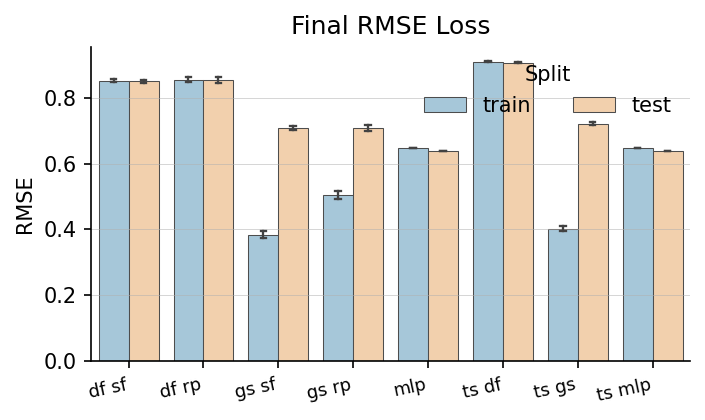

In [8]:
bar_scatter_2(df[df["metric"] == "rmse"],  title="Final RMSE Loss",  ylabel="RMSE")

/tmp/ipykernel_1496163/1886384733.py:17: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.1}` instead.

  sns.barplot(
/tmp/ipykernel_1496163/1886384733.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


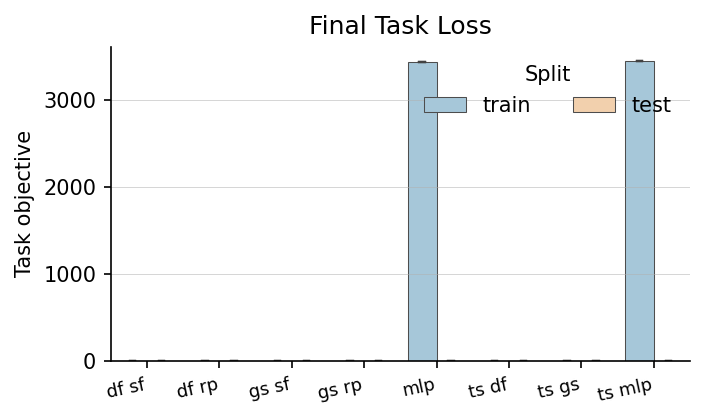

In [9]:
bar_scatter_2(df[df["metric"] == "task"], title="Final Task Loss",  ylabel="Task objective")

/tmp/ipykernel_1496163/1924870626.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_1496163/1924870626.py:48: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.0}` instead.

  sns.barplot(
/tmp/ipykernel_1496163/1924870626.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(
/tmp/ipykernel_1496163/1924870626.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_1496163/1924870626.py:48: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kw

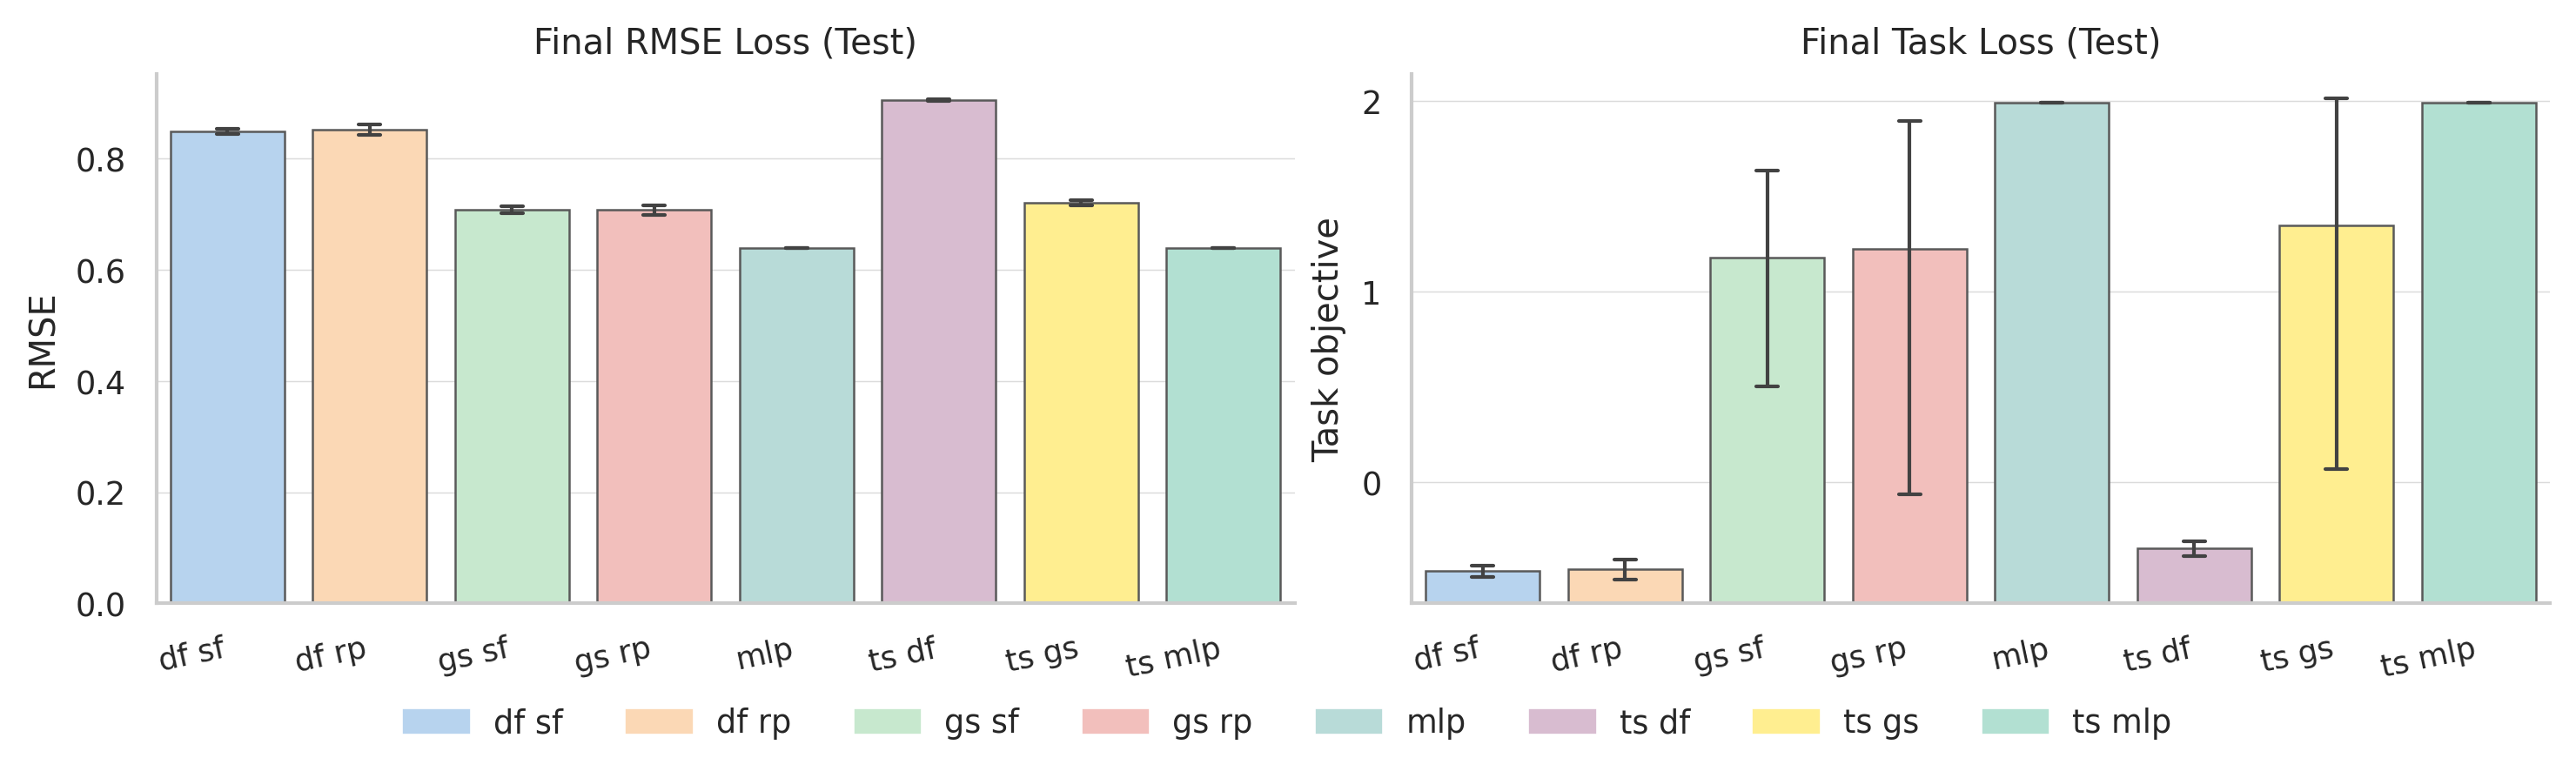

In [10]:
import matplotlib.colors as mcolors
from matplotlib.ticker import LogLocator, FuncFormatter, NullLocator
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

BLUE   = "#6FA8DC"
ORANGE = "#F6B26B"
GREEN  = "#8FD19E"
CORAL  = "#E57F7A"
TEAL   = "#72B7B2"
MAUVE  = "#B279A2"
AMBER  = "#FFDE21"
OKABE_ITO = [BLUE, ORANGE, GREEN, CORAL, TEAL, MAUVE, AMBER]

def lighten_hex(c, amt=0.1):
    rgb = np.array(mcolors.to_rgb(c))
    return mcolors.to_hex((1-amt)*rgb + amt*np.ones_like(rgb))

def build_baseline_palette(categories, base=None, amt=0.1):
    base = (base or OKABE_ITO).copy()
    if len(categories) > len(base):
        base += sns.color_palette("Set2", n_colors=len(categories)-len(base)).as_hex()
    soft = [lighten_hex(c, amt) for c in base]
    return {cat: soft[i] for i, cat in enumerate(categories)}

tasks_all = list(df[df["metric"].isin(["rmse", "task"])]["task"].unique())
BASELINE_COLORS = build_baseline_palette(tasks_all, amt=0.5)


def bar_scatter_ax(sub_df, ax, title: str, ylabel: str, *, logy=False, show_legend=True):
    sub_df = sub_df.copy()

    sub_df = sub_df[~sub_df["split"].str.lower().str.contains("train")]
    lower = sub_df["split"].str.lower()
    if "test" in set(lower.unique()):
        sub_df = sub_df[lower == "test"]
        split_used = "Test"
    elif {"val","valid","validation"} & set(lower.unique()):
        sub_df = sub_df[lower.isin(["val","valid","validation"])]
        split_used = "Val"
    else:
        split_used = None

    tasks_order = list(sub_df["task"].unique())
    palette_for_x = {t: BASELINE_COLORS[t] for t in tasks_order}

    sns.barplot(
        data=sub_df, x="task", y="value_sum",
        ax=ax, order=tasks_order,
        palette=[palette_for_x[t] for t in tasks_order],
        estimator=np.mean, errorbar="sd",
        capsize=0.15, errwidth=1.0,
        edgecolor="0.35", linewidth=0.6,
        saturation=1.0,
        # err_kws={"color": "0.35", "elinewidth": 1.0, "alpha": 0.9}  # 误差棒稍深更清晰
    )

    ax.set_ylabel(ylabel)
    ax.set_xlabel("")
    ttl = f"{title}" + (f" ({split_used})" if split_used else "")
    ax.set_title(ttl, pad=6)
    ax.grid(axis="y", linewidth=.35, alpha=.7)

    ax.set_xticklabels(
        [TASK_LABEL.get(t.get_text(), t.get_text()) for t in ax.get_xticklabels()],
        rotation=12, ha="right", fontsize=8.5
    )

    if logy:
        ax.set_yscale("log")
    else:
        if "Task" in title:
            ax.set_ylim(1, 4)

    if show_legend:
        import matplotlib.patches as mpatches
        patches = [mpatches.Patch(color=palette_for_x[t], label=TASK_LABEL.get(t, t))
                   for t in tasks_order]
        ax.legend(handles=patches, title="Baseline", frameon=False,
                  ncol=min(4, len(tasks_order)), loc="upper right")
    else:
        if ax.legend_ is not None:
            ax.legend_.remove()

    sns.despine(ax=ax, top=True, right=True)


sns.set_theme(style="whitegrid", context="paper")
fig, axes = plt.subplots(1, 2, figsize=(9.8, 3.0), dpi=300)

bar_scatter_ax(df[df["metric"] == "rmse"],  axes[0], "Final RMSE Loss",  "RMSE",
               logy=False)
bar_scatter_ax(df[df["metric"] == "task"], axes[1], "Final Task Loss",  "Task objective",
               logy=True)
ax = axes[1]
ax.set_yscale('log', base=2)
ax.yaxis.set_major_locator(LogLocator(base=2))
ax.yaxis.set_minor_locator(NullLocator())
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{int(y)}"))

fig.tight_layout(pad=.5, rect=[0, 0.18, 1, 1])

for ax in axes:
    leg = ax.get_legend()
    if leg is not None:
        leg.remove()

import matplotlib.patches as mpatches
handles = [mpatches.Patch(color=BASELINE_COLORS[t], label=TASK_LABEL.get(t, t))
           for t in tasks_all]

fig.legend(handles=handles, loc="lower center",
           ncol=max(1, len(handles)), frameon=False,
           bbox_to_anchor=(0.5, 0.03))

fig.subplots_adjust(bottom=0.24)

plt.savefig("synthetic_baselines.pdf", bbox_inches="tight", format="pdf", dpi=300)
plt.show()


/tmp/ipykernel_1496163/1924870626.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_1496163/1924870626.py:48: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.0}` instead.

  sns.barplot(
/tmp/ipykernel_1496163/1924870626.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


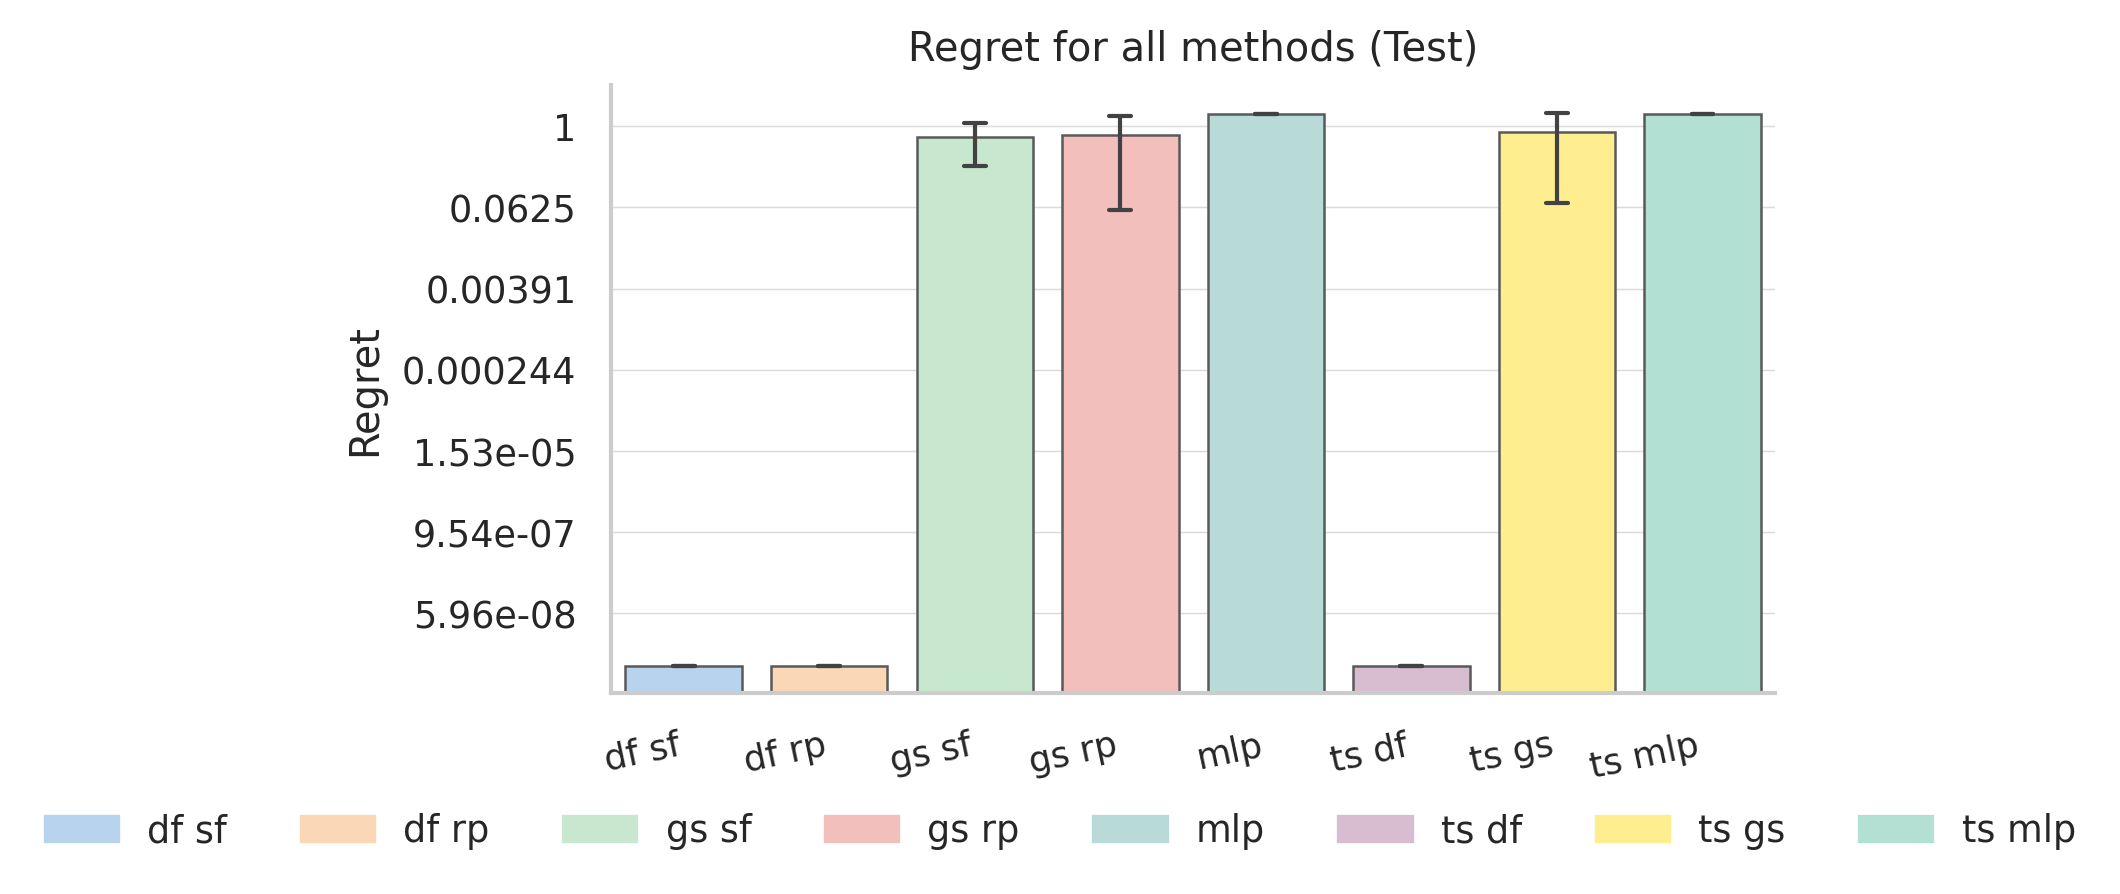

In [11]:
OPT = 0.4527

df_regret = df[df["metric"] == "task"].copy()
df_regret["regret"] = (df_regret["value_sum"] - OPT).clip(lower=0.0)
df_regret["value_sum"] = df_regret["regret"].clip(lower=1e-8)

sns.set_theme(style="whitegrid", context="paper")
fig_r, ax_r = plt.subplots(1, 1, figsize=(4.9, 3.0), dpi=300)

bar_scatter_ax(
    df_regret,
    ax_r,
    title=f"Regret for all methods",
    ylabel="Regret",
    logy=True,
    show_legend=True
)

ax_r.set_yscale('log', base=2)
ax_r.yaxis.set_major_locator(LogLocator(base=2))
ax_r.yaxis.set_minor_locator(NullLocator())
ax_r.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.3g}"))

for lg in [ax_r.get_legend()]:
    if lg is not None:
        lg.remove()

import matplotlib.patches as mpatches
handles_r = [mpatches.Patch(color=BASELINE_COLORS[t], label=TASK_LABEL.get(t, t))
             for t in tasks_all]
fig_r.legend(handles=handles_r, loc="lower center",
             ncol=max(1, len(handles_r)), frameon=False,
             bbox_to_anchor=(0.5, 0.03))

fig_r.tight_layout(pad=.5, rect=[0, 0.18, 1, 1])
fig_r.subplots_adjust(bottom=0.24)

plt.savefig("synthetic_regret.pdf", bbox_inches="tight", format="pdf", dpi=300)
plt.show()


In [ ]:
df["value_sum"] = pd.to_numeric(df["value_sum"], errors="coerce")

test_df = df[df["split"].str.lower() == "test"].copy()

test_df["label"] = test_df["task"].astype(str).map(lambda t: TASK_LABEL.get(t, t))

stats = (
    test_df.groupby(["metric", "task"], observed=True, as_index=False)["value_sum"]
    .agg(
        mean="mean",
        var=lambda x: x.var(ddof=1),
        std=lambda x: x.std(ddof=1),
        n="size",
    )
)

stats["label"] = stats["task"].astype(str).map(lambda t: TASK_LABEL.get(t, t))
stats["std_error"] = stats["std"] / np.sqrt(stats["n"].astype(float))

stats = stats[["metric", "task", "label", "mean", "var", "std", "std_error", "n"]]

out_all = os.path.join(save_folder, "synthetic_baselines_stats.csv")
stats.to_csv(out_all, index=False)
print(f"Saved: {out_all}")

for m in ["rmse", "task"]:
    sub = stats[stats["metric"] == m].drop(columns=["metric"])
    out_m = os.path.join(save_folder, f"synthetic_baselines_stats_{m}.csv")
    sub.to_csv(out_m, index=False)
    print(f"Saved: {out_m}")

print(stats)

In [39]:
def get_test_task_loss(df, baseline="two_stage_diffusion"):
    d = df.copy()
    d["split"] = d["split"].str.lower()

    sub = d[(d["metric"] == "task") &
            (d["task"] == baseline) &
            (d["split"] == "test")]
    if sub.empty:
        sub = d[(d["metric"] == "task") &
                (d["task"] == baseline) &
                (d["split"].isin(["val", "valid", "validation"]))]

    if sub.empty:
        raise ValueError(f"No rows for baseline={baseline!r} with metric='task' (test/val).")

    mean = sub["value_sum"].mean()
    std  = sub["value_sum"].std(ddof=1)
    n    = len(sub)
    return {"mean": float(mean), "std": float(std), "n": int(n),
            "sem": float(std/np.sqrt(n)) if n>0 else np.nan}
out = get_test_task_loss(df, baseline="two_stage_diffusion")
print(f"two_stage_diffusion Test Task Loss: "
      f"mean={out['mean']:.4f}, std={out['std']:.4f}, n={out['n']}")


two_stage_diffusion Test Task Loss: mean=4.2337, std=5.0858, n=10


/tmp/ipykernel_1106221/1199983907.py:12: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.1}` instead.

  sns.barplot(
/tmp/ipykernel_1106221/1199983907.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(
/tmp/ipykernel_1106221/1199983907.py:12: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.1}` instead.

  sns.barplot(
/tmp/ipykernel_1106221/1199983907.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


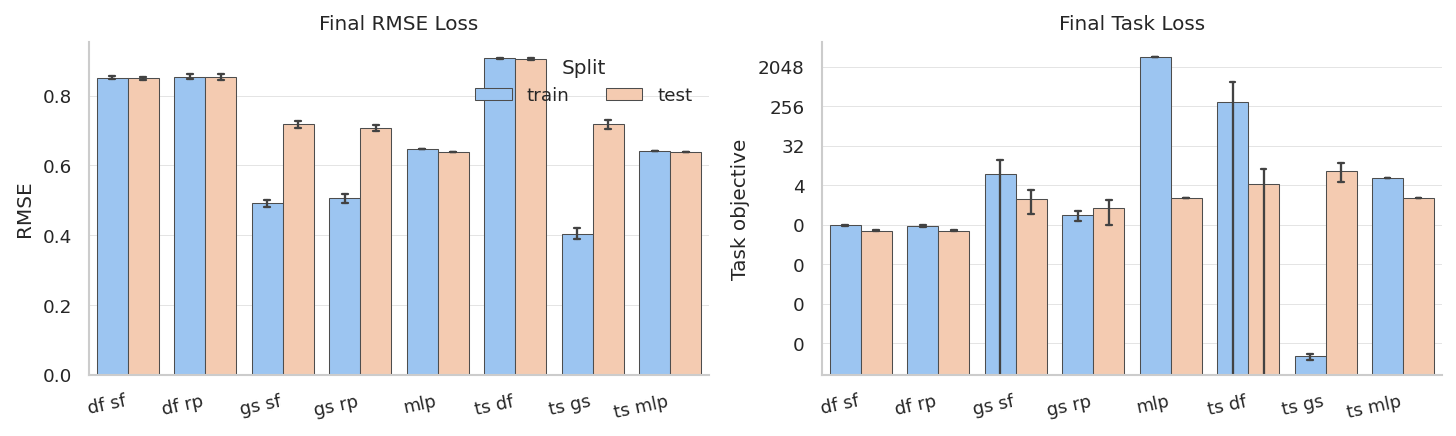

In [40]:
LIGHT_BLUE  = "#8EC5FF"
LIGHT_ORANGE= "#FFC9A6"

def bar_scatter_ax(sub_df, ax, title: str, ylabel: str, *, logy=False, show_legend=True):
    # palette
    if len(splits) <= 2:
        palette = [LIGHT_BLUE, LIGHT_ORANGE][:len(splits)]
    else:
        extra = sns.color_palette("Greys", n_colors=len(splits)-2)
        palette = [LIGHT_BLUE, LIGHT_ORANGE] + extra

    sns.barplot(
        data=sub_df,
        x="task", y="value_sum", hue="split",
        ax=ax, palette=palette, dodge=True,
        estimator=np.mean, errorbar="sd",
        capsize=0.15, errwidth=1.1,
        edgecolor="0.30", linewidth=0.5,
    )

    ax.set_ylabel(ylabel)
    ax.set_xlabel("")
    ax.set_title(title, pad=6)
    ax.grid(axis="y", linewidth=.35, alpha=.7)

    ax.set_xticklabels(
        [TASK_LABEL.get(t.get_text(), t.get_text()) for t in ax.get_xticklabels()],
        rotation=12, ha="right", fontsize=8.5
    )

    if logy:
        ax.set_yscale("log")
    else:
        if "Task" in title:
            ax.set_ylim(1, 4)

    if show_legend:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[:len(splits)], labels[:len(splits)],
                  title="Split", frameon=False, ncol=min(3, len(splits)),
                  loc="upper right")
    else:
        ax.legend_.remove()

    sns.despine(ax=ax, top=True, right=True)

# ---- make the 1x2 figure ----
fig, axes = plt.subplots(1, 2, figsize=(9.8, 3.0), dpi=150)

bar_scatter_ax(df[df["metric"] == "rmse"],  axes[0], "Final RMSE Loss",  "RMSE",
               logy=False, show_legend=True)

bar_scatter_ax(df[df["metric"] == "task"], axes[1], "Final Task Loss",  "Task objective",
               logy=True, show_legend=False)

from matplotlib.ticker import LogLocator, FuncFormatter, NullLocator

ax = axes[1]
ax.set_yscale('log', base=2)
ax.yaxis.set_major_locator(LogLocator(base=2))
ax.yaxis.set_minor_locator(NullLocator())

ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{int(y)}"))

plt.tight_layout()
plt.savefig("power_sched_baselines.pdf", bbox_inches="tight", format="pdf", dpi=300)
plt.show()
